(chap_microscope_types)=
# Microscopes & detectors 

:::{admonition} Chapter outline 
:class: tip

* The **choice of microscope** influences the **blur**, **noise** & **temporal resolution** of images 
* An **ideal detector** would have a high **Quantum Efficiency** & **low read noise**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction 

Successfully analyzing an image requires that it actually contains the necessary information in the first place.
There are various practical issues related to the biology (e.g. not interfering too much with processes, for example by inadvertently killing things) and data handling (bit-depths, file formats, anything else in Part I of this book).
However, assuming that these are in order, there are three other main factors to consider connected to the image contents: 

1.  **Spatial information**, dependent on the size and shape of the PSF, 
2.  **Noise**, dependent on the number of photons detected, 
3.  **Temporal resolution**, dependent on the speed at which the microscope can record images. 

No one type of microscope is currently able to optimize all of these simultaneously, and so decisions and compromises need to be made.
Temporal resolution and noise have an obvious relationship: a high temporal resolution means that less time is spent detecting photons in the image, leading to more photon noise.
However, improving spatial information is also often related to one or both of the other two factors. 

This chapter gives a very brief overview of the main features of several fluorescence microscopes from the point of view of how they balance the tradeoffs mentioned.

:::{warning}
**This discussion does _not_ do justice to all the complexities, variations and features of the microscopes it describes!**

I'm by no means an expert in microscopy: I just analyze the data.
But this chapter tries to distil the main things I learned that are relevant for analysis while working in an imaging center.
It's a bit dated, but I've kept it anyway in case it might be useful to someone as a starting point.

For a more extensive, and authoritative, description of the topics considered here, consider seeking out the _Handbook of Biological Confocal Microscopy_ edited by James Pawley.
This contains many excellent chapters, some of which may be available to download from the publisher's website.
:::


## Types of microscope

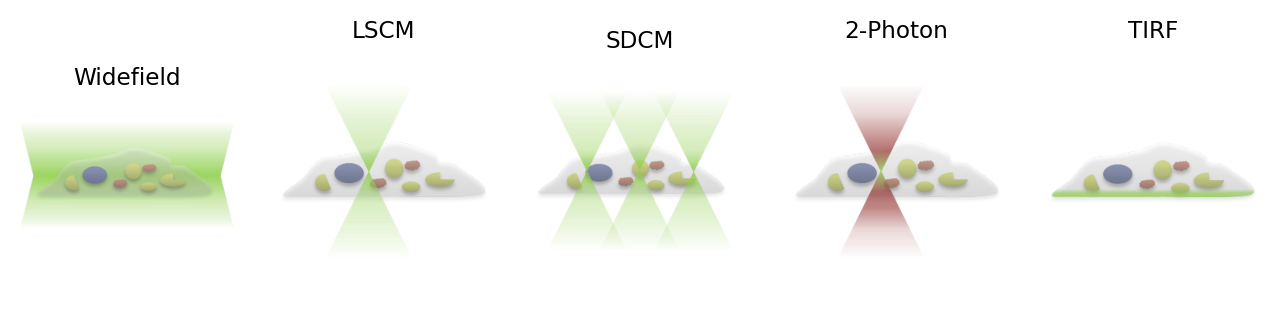

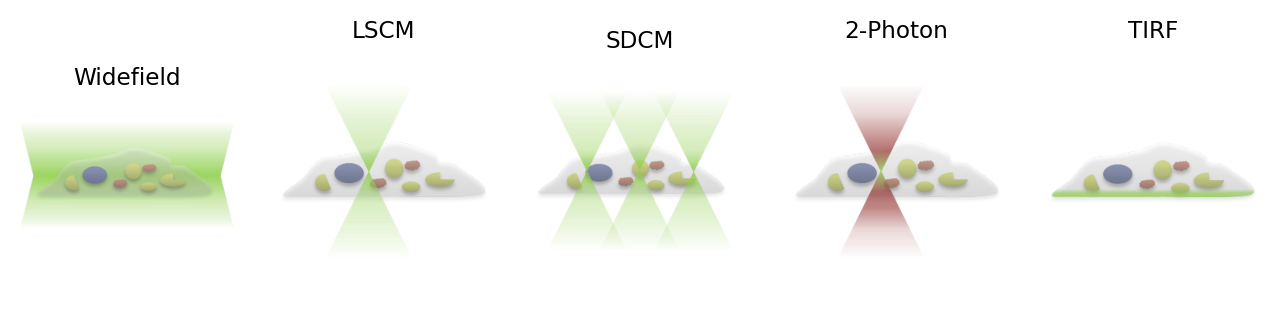

In [2]:
fig = create_figure(figsize=(8, 4))
show_image('images/excite_widefield.png', title='Widefield', pos=151)
show_image('images/excite_confocal.png', title='LSCM', pos=152)
show_image('images/excite_spinning_disc.png', title='SDCM', pos=153)
show_image('images/excite_2p.png', title='2-Photon', pos=154)
show_image('images/excite_tirf.png', title='TIRF', pos=155)
glue_fig('fig_microscopes_types', fig)

```{glue:figure} fig_microscopes_types
---
align: center
name: fig-excitation
---

Schematic diagrams to show the differences in excitation patterns.
Here, an inverted microscope is assumed (the cell is resting on a coverslip, and illuminated from below).
During the recording of a pixel, light can potentially be detected if it arises from any part of the green-illuminated region, although in the laser scanning and spinning disk confocal cases the pinhole will only permit a fraction of this light to pass through.
Note that, for the 2-photon microscope, the excitation is confined to only the small, central region, while the red light above and below is not capable of exciting the fluorophores that have been used. 
``` 


### Widefield 

So far, our schematic diagrams and PSF discussion have concentrated on **widefield microscopes**.
In widefield microscopy, the entire sample is bathed in light, so that many fluorophores throughout the sample can be excited and emit photons simultaneously.
All of the light that enters the objective may then be detected and contribute to any image being recorded.
Because photons are potentially emitted from everywhere in the sample, there will be a lot of blur present for a thick specimen (for a thin specimen there is not much light from out-of-focus planes because the planes simply do not contain anything that can fluoresce).

What we get in any single recorded image is effectively the sum of the light from the in-focus plane, and every other out-of-focus plane.
Viewed in terms of PSFs, we capture part of the hourglass shape produced by every light-emitting point depending upon how in-focus it is in every image. 

This is bad news for spatial information and also for detecting small structures in thick samples, because the out-of-focus light is essentially unhelpful background.
On the other hand, widefield images tend to include a lot of photons, which overcomes read noise, even when they are recorded fast. 

### Laser scanning confocal 

**Optical sectioning** is the ability to detect photons only from the plane of focus, rejecting those from elsewhere.
This is necessary to look into thick samples without getting lost in the haze of other planes.
**Laser Scanning Confocal Microscopy (LSCM)** achieves this by only concentrating on detecting light for one pixel at any time, and using a pinhole to try to only allow light from a corresponding point in the sample to be detected. 

Because at most only one pixel is being recorded at any given moment, it does not make sense to illuminate the entire sample at once, which could do unnecessary damage.
Rather, a laser illuminates only a small volume.
If this would be made small enough, then a pinhole would not actually be needed because we would know that all emitted light _must_ be coming from the illuminated spot; however, the illumination itself is like an hour-glass PSF in the specimen.
The pinhole is needed to make sure only the light from the central part reaches the detector.
This then causes the final PSF, as it appears _in the image_, to take on more of a rugby-ball (or American football) appearance. 

The end result is an image that has relatively little out-of-focus light.
Compared to widefield microscopy, LSCM provide a significant improvement in what can be seen along the *z*-dimension, although the *xy* resolution is not very different.
Also, because single pixels are recorded separately, the image can (potentially) be more or less any size and shape -- rather than limited by the pixel count on a camera. 

However, these advantages comes with a major drawback.
Images usually contain thousands to millions of pixels, and so only a tiny fraction of the time required to record an image is spent detecting photons for any one pixel in a LSCM image -- unlike in the widefield case, where photons can be detected for all pixels over the entire image acquisition time. This can cause LSCM image acquisition to be comparatively slow, noisy (in terms of few detected photons) or both.
Spatial information is therefore gained at a cost in noise and/or temporal resolution. 


```{tabbed} Question 
:new-group: 

Why is it often recommended that the pinhole in LSCM be set to have the same size as one Airy disk? And why is it sometimes better not to strictly follow this recommendation? 
``` 


```{tabbed} Solution 

As described in {ref}`chap_formation_spatial`, the vast majority of the light from the in-focus plane falls within the Airy disk.
Using a pinhole smaller than this can result in so little light being detected that the image becomes too noisy to be useful.
On the other hand, increasing the size of the pinhole will result in some more of the remaining light located in the outer rings of the Airy pattern, but _most_ extra photons will come from out-of-focus planes.
This causes a reduction in the effectiveness of the optical sectioning.
Therefore, a pinhole diameter of approximately 1 Airy disk provides a reasonable balance between detecting most of the in-focus light and achieving good optical sectioning. 

Nevertheless, sometimes a reduction in optical sectioning is a worthwhile cost -- such as when photons are very scarce, and some extra background is tolerable.
Also, when recording a multichannel image then you may well have to set the pinhole size according to the Airy disk for one channel.
But because the size of the disk depends upon the light wavelength (as described in Equation {eq}`eqn-res_lateral`), the pinhole diameter will differ in terms of Airy disk sizes for other channels. 
``` 

### Spinning disk confocal 

So a widefield system records all pixels at once without blocking the light from reaching the detector anywhere, whereas a LSCM can block out-of-focus light by only recording a single pixel at a time.
Both options sound extreme: could there not be a compromise? 

**Spinning disk confocal microscopy (SDCM)** implements one such compromise by using a large number of pinholes punched into a disk, so that the fluorophores can be excited and light detected for many different _non-adjacent_ pixels simultaneously.
By not trying to record adjacent pixels at the same time, pinholes can be used to block _most_ of the out-of-focus light for each pixel, since this originates close to the region of interest for that pixel (i.e. the PSF becomes very dim at locations far away from its center) -- but sufficiently-spaced pixels can still be recorded simultaneously with little influence on one another. 

In practice, spinning disk confocal microscopy images are likely to be less sharp than laser scanning confocal images because some light does scatter through other pinholes.
Also, the pinhole sizes cannot be adjusted to fine-tune the balance between noise and optical sectioning. However, the optical sectioning offered by SDCM is at least a considerable improvement over the widefield case, and an acceptable SNR can be achieved with much faster frame-rates using SDCM as opposed to LSCM. 

### Multiphoton microscopy 

As previously mentioned, if the size of excitation volume could be reduced enough, then we would know where the photons originated even without a pinhole being required -- but focused excitation is generally still subject to PSF-related issues, so that fluorophores throughout a whole hourglass-shaped volume can end up being excited.
The main idea of **multiphoton microscopy** is that fluorophore excitation requires the _simultaneous absorption of multiple photons_, rather than only a single photon.
The excitation light has a longer wavelength than would otherwise be required to cause molecular excitation with a single photon, but the energies of the multiple photons combine to cause the excitation. 

The benefit of this is that the multiphoton excitation only occurs at the focal region of the excitation -- elsewhere within the 'specimen PSF' the light intensities are insufficient to produce the 'multiphoton effect' and raise the fluorophores into an excited state.
This means that the region of the specimen emitting photons at any one time is much smaller than when using single photon excitation (as in LSCM), and also less damage is being caused to the sample.
Furthermore, multiphoton microscopy is able to penetrate deeper into a specimen -- up to several hundred µm. 

### Total Internal Reflection Fluorescence 

As previously mentioned, widefield images of very thin specimens do not suffer much from out-of-focus blur because light is not emitted from many other planes.
**Total Internal Reflection Fluorescence (TIRF)** microscopy makes use of this by stimulating fluorescence only in a very thin section of the sample close to the objective.
Very briefly, TIRF microscopy involves using an illumination angled so that the change in refractive index encountered by the light as it approaches the specimen causes a further change in angle sufficient to prevent the light from directly entering the specimen (i.e. it is 'totally internally reflected').
Nevertheless, fluorophores can still be excited by an evanescent wave that is produced when this occurs.
This wave decays exponentially, so that only fluorophores right at the surface are excited -- meaning fluorophores deeper within the specimen do not interfere with the recording. 

Importantly, because the subsequent recording is essentially similar to that used when recording widefield images, photons are detected at all pixels in parallel and fast recording-rates are possible.
Therefore if it's only necessary to see to a depth of about 100 nm, TIRF microscopy may be a good choice. 

## Photon detectors 

Certain detectors are associated with certain types of microscopy, and differ according to the level and type of noise you can expect.
Understanding the basic principles greatly helps when choosing sensible values for parameters such as gain, pixel size and binning during acquisition to optimize the useful information in the image.
The following provides a very brief introduction to two common detectors, and extra one variation. 

### PMTs: one pixel at a time 

If you only need to record one pixel at a time, a **photomultiplier tube (PMT)** might be what you need.
The basic principle is this: a photon strikes a photocathode, hopefully producing an electron.
When this occurs, the electron is accelerated towards a dynode, and any produced electrons accelerated towards further dynodes.
By adjusting the 'gain', the acceleration of the electrons towards successive dynodes can be varied; higher accelerations mean there is an increased likelihood that the collision of the electrons with the dynode will produce a higher number of electrons moving into the next stage.
The charge of the electrons is then quantified at the end ({numref}`fig-pmt`).
Because the (possibly very small) number of original detected photons have now been amplified to a (possibly much) larger number electrons by the successive collisions with dynodes, the effect of read noise is usually minor for a PMT. 

```{figure} images/pmt.png
---
align: center
width: 60%
name: fig-pmt
---
Diagram showing the detection of a photon by a PMT.
Each photon can be 'multiplied' to produce many electrons by accelerating the first produced electron towards a dynode, and repeating the process for all electrons produced along a succession of dynodes.
The charge of the electrons reaching the end of the process can then be quantified, and ought to be proportional to the number of photons that arrived at the PMT.
``` 


More problematically, PMTs can suffer from the problem of having a low **Quantum Efficiency (QE)**.
The QE is a measure of the proportion of photons striking the detector which then produce electrons, and values for a conventional PMT may be as low as 10–15%: the majority of the photons reaching the PMT are simply wasted.
Thus photon noise can be a major issue, especially if there is a low amount of light available to detect in the first place. 


:::{admonition} Converting electrons to pixels 
:class: info

It's important to keep in mind that the final pixel values are not _equal_ to numbers of detected photons -- nor even numbers of counted electrons.
They are rather proportional, often with an offset added.

It's essential to estimate this offset (perhaps from a background region or an image acquired without using any excitation light) and subtract it if you need to compare pixel values in different images, in addition to using identical acquisition settings. 
::: 

### CCDs: fast imaging when there are a lot of photons 

A **Charged Coupled Device (CCD)** is a detector with a region devoted to sensing photons, and which is subdivided into different 'physical pixels' that correspond to pixels in the final image.
Thus the image size cannot be changed arbitrarily, but it's possible to record photons for many pixels in parallel. 

When a photon strikes a pixel in the sensing part of the CCD, this often releases an electron -- the QE is typically high (perhaps 90%).
After a certain exposure time, different 'electron clouds' have then formed at each physical pixel on the sensor, each of which has a charge related to the number of colliding photons.
This charge is then measured by passing the electrons through a charge amplifier, and the results used to assign an intensity value to the pixel in the final image ({numref}`fig-ccd`).

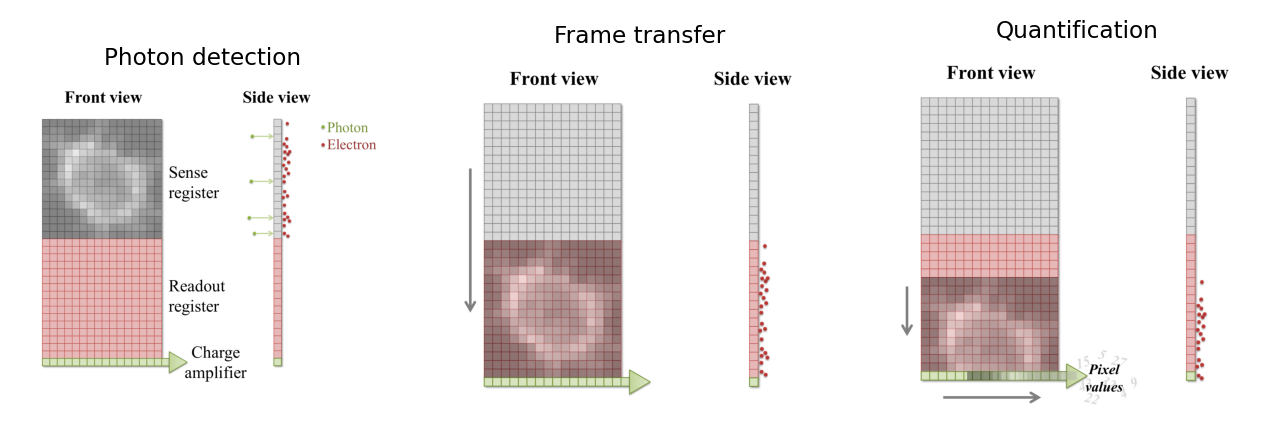

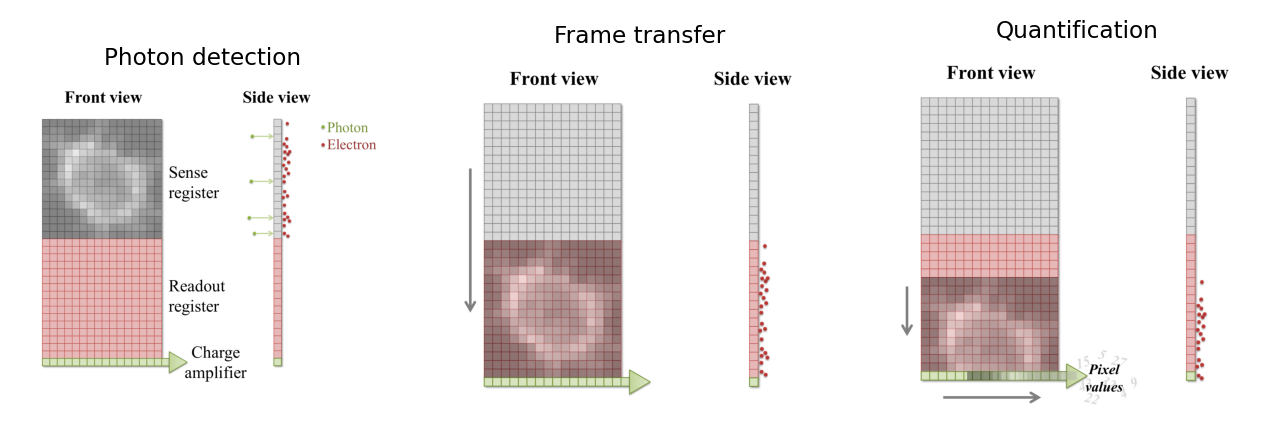

In [3]:
fig = create_figure(figsize=(8, 4))
show_image('images/ccd_1.png', title='Photon detection', pos=131)
show_image('images/ccd_2.png', title='Frame transfer', pos=132)
show_image('images/ccd_3.png', title='Quantification', pos=133)
glue_fig('fig_microscopes_ccd', fig)

```{glue:figure} fig_microscopes_ccd
---
align: center
name: fig-ccd
---

An illustration of the basic operation of a CCD camera (using frame transfer).
First, photons strike a sense register, which is divided into pixels.
This causes small clouds of electrons to be released and gather behind the pixels (A).
These are then rapidly shifted downwards into another register of the same size, thereby freeing the sense register to continue detecting photons (B).
The electron clouds are then shifted downwards again, one row at a time, with each row finally being shifted sequentially through a charge amplifier \(C).
This quantifies the charge of the electron clouds, from which pixel values for the final image are determined. 
``` 


The electron clouds for each pixel might be larger than in the PMT case, both because of the higher QE and because more time can be spent detecting photons (since this is carried out for all pixels simultaneously).
However, the step of amplifying the numbers of electrons safely above the read noise before quantification is missing. Consequently, read noise is potentially more problematic, and in some cases can even dominate the result. 

(sec_detectors_binning)=
### Pixel binning 

One way to address the issue of CCD read noise is to use **pixel binning**.
In this case, the electrons from 4 (i.e. 2×2) pixels of the CCD are added together before being quantified: the electron clouds are approximately 4 times bigger relative to the read noise ({numref}`fig-ccd_binning`), and readout can be faster because fewer electron clouds need to be quantified.
The obvious disadvantage of this is that one cannot then put the electrons from the 4 pixels 'back where they belong'.
As a result, the binned measurement is simply treated as a single (bigger) pixel.
The recorded image contains 25% of the pixels in the unbinned image, while still covering the same field of view, so spatial information is lost.
Larger bins may also be used, with a correspondingly more dramatic impact upon image size ({numref}`fig-ccd_binning`D).

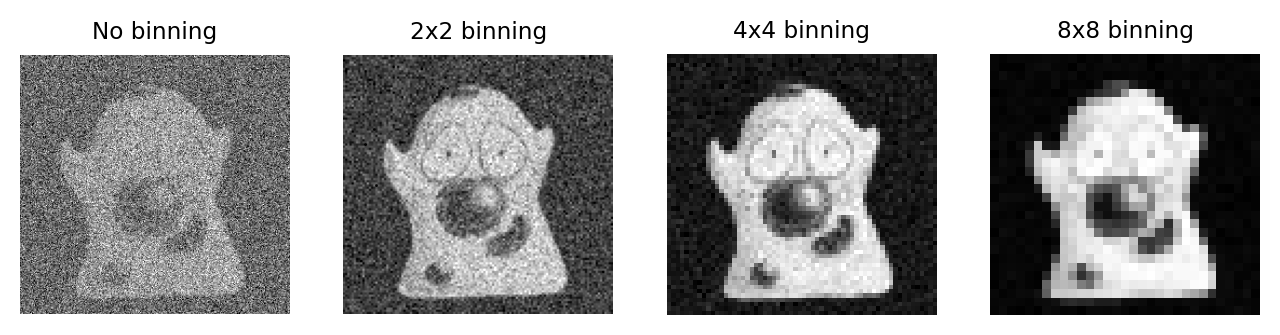

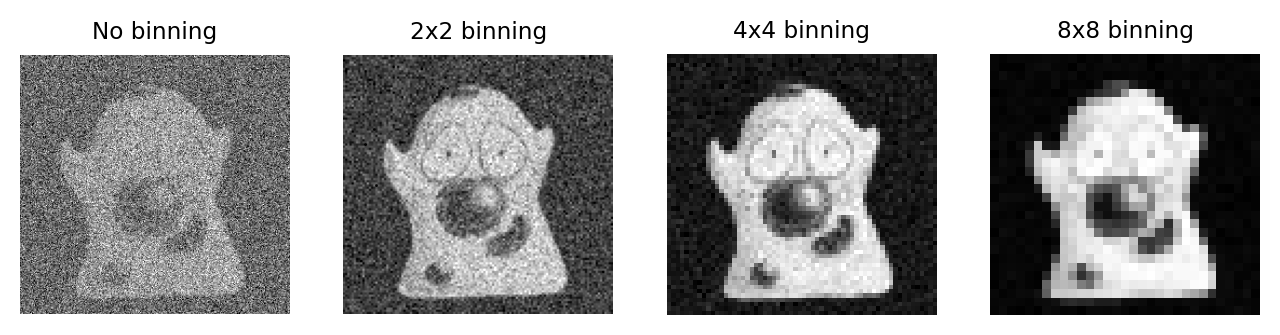

In [4]:
import numpy as np

def bin2x2(im):
    """
    Apply 2x2 binning to the pixels of a 2D image.
    Note that if the dimensions are not even numbers then the final row/column 
    of pixels may have to be trimmed.
    """
    r = int(np.floor(im.shape[0]/2)*2)
    c = int(np.floor(im.shape[1]/2)*2)
    return im[0:r:2, 0:c:2] + im[1:r:2, 0:c:2] + im[0:r:2, 1:c:2] + im[1:r:2, 1:c:2]

# Simulate larger bins by progressively applying 2x2 binning
im = load_image('happy_cell.tif')
im = im.astype(np.float32)

# Add a little photon noise
rng = np.random.default_rng(1012)
im = rng.poisson(1 + im).astype(np.float32)

# Create binned images
im2 = bin2x2(im)
im4 = bin2x2(im2)
im8 = bin2x2(im4)
im16 = bin2x2(im8)

# Define a fixed read noise standard deviation & apply it
read_noise_sigma = 50
im += rng.normal(scale=read_noise_sigma, size=im.shape)
im2 += rng.normal(scale=read_noise_sigma, size=im2.shape)
im4 += rng.normal(scale=read_noise_sigma, size=im4.shape)
im8 += rng.normal(scale=read_noise_sigma, size=im8.shape)

# Show images with read noise added
fig = create_figure((8, 3))
show_image(im, clip_percentile=0.5, title='No binning', pos=(141))
show_image(im2, clip_percentile=0.5, title='2x2 binning', pos=(142))
show_image(im4, clip_percentile=0.5, title='4x4 binning', pos=(143))
show_image(im8, clip_percentile=0.5, title='8x8 binning', pos=(144))

glue_fig('fig_microscopes_ccd_binning', fig)

```{glue:figure} fig_microscopes_ccd_binning
---
align: center
name: fig-ccd_binning
---

Illustration of the effect of binning applied to an image suffering from photon and (severe) read noise.
As the bin size increases, the photons from neighboring pixels are combined into a single (larger) pixel before the read noise is added.
As a consequence, the image becomes brighter relative to the read noise -- but at a cost of spatial information. 
``` 


### EMCCDs: fast imaging with low light levels 

And so you might wonder whether it is possible to increase the electron clouds (like with the PMT) with an CCD, and so get its advantages without the major inconvenience of read noise.
**Electron Multiplying CCDs (EMCCDs)** achieve this to some extent.
Here, the electrons are first passed through an additional 'gain register' before quantification.
At every stage of this gain register, each electron has a small probability -- perhaps only 1% -- of being amplified (through 'impact ionisation') and giving rise to two electrons entering the next stage.
Despite the small probability, by incorporating > 500 such stages, the size of the electron cloud arising from even a single photon may be amplified safely above the read noise. 

However, the randomness of the amplification process itself introduces a new source of uncertainty, so that the final outcome can be thought of as having the same precision as if perhaps only around half as many photons were detected (see {ref}`chap_formation_noise` for the relationship between noise and the number of photons).
Therefore read noise is effectively overcome at the cost of more photon noise.

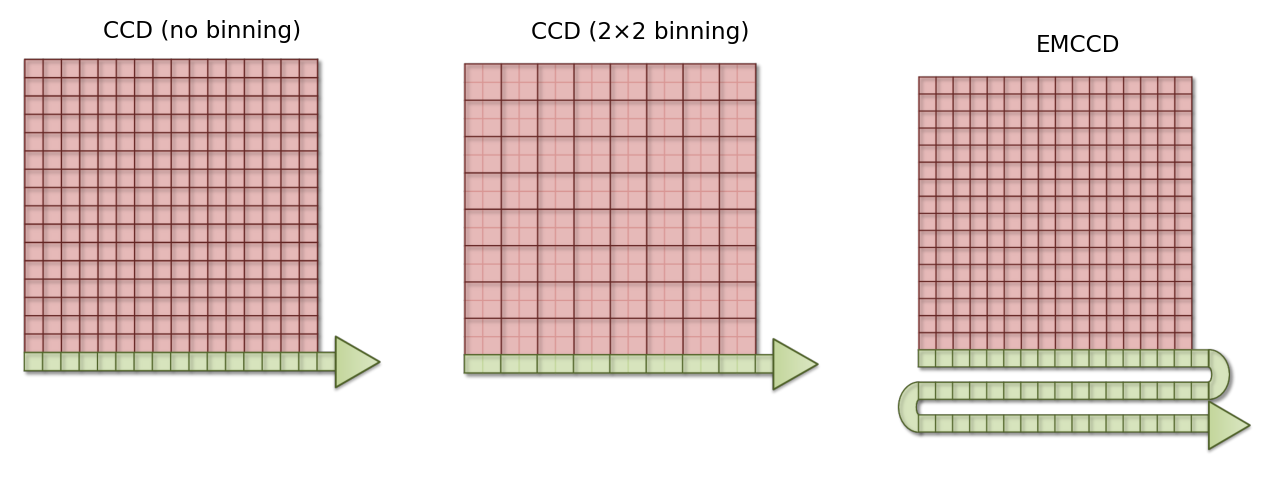

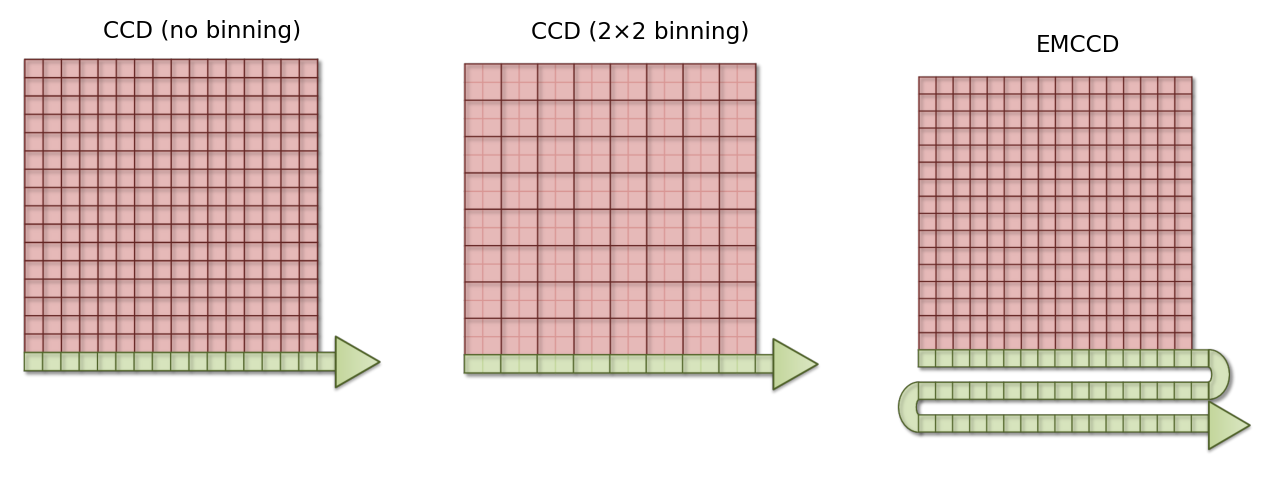

In [5]:
fig = create_figure(figsize=(8, 4))
show_image('images/ccd_conventional.png', title='CCD (no binning)', pos=131)
show_image('images/ccd_binned.png', title='CCD (2×2 binning)', pos=132)
show_image('images/ccd_em.png', title='EMCCD', pos=133)
glue_fig('fig_microscopes_ccd_types', fig)

```{glue:figure} fig_microscopes_ccd_types
---
align: center
name: fig-ccd_types
---
A simplified diagram comparing a conventional CCD (with and without binning) and an EMCCD.
While each has the same physical number of pixels, when binning is used electrons from several pixels are combined before readout -- thereby making the 'logical' pixels in the final image bigger.
For the EMCCD, the electrons are shifted through a 'gain register' prior to quantification.
See {numref}`fig-ccd` for additional labels; the sense register has been omitted for simplicity. 
``` 


```{tabbed} Question 
:new-group: 

From a practical point of view, an EMCCD is rather like having a CCD with no read noise, but with half the QE.
Under what circumstances (i.e. high or low numbers of photons) is an EMCCD preferable to a CCD? 
``` 


```{tabbed} Solution 

The gain register of EMCCDs offers benefits primarily when few photons are available (i.e. when read-noise is the main problem, such as in SDCM).
CCDs are preferable when many photons are available (e.g. in widefield). 

If you are skeptical about this, consider an image in which your read noise standard deviation is 10 electrons and you detect on average 9 electrons (originally photons).
The photon noise then has a standard deviation of 3.
The read noise is much larger and will completely dominate the image: nothing interesting will be visible.
It's then worth the cost of even more photon noise to be able to eliminate the read noise.
The final image will still look pretty bad, but at least interpreting it is not hopeless. 

But suppose you happen to have 90000 detected photons instead, in which case the standard deviation of the photon noise is now 300.
The read noise of 10 is comparatively insignificant, and there is nothing to gain from electron multiplication and making the photon noise situation worse. 
``` 


```{tabbed} Question 
:new-group: 

Based upon the above descriptions, which detectors seem most appropriate (generally!) for (a) widefield microscopy, (b) SDCM and (c) LSCM? 
``` 


```{tabbed} Solution 

The following are reasonable rules of thumb: 


* _Widefield microscopy:_ A CCD is suitable because of its ability to record many pixels simultaneously.
The large number of photons normally detected means that read noise is not usually a big issue, and an EMCCD can make the problem of noise worse instead of better. 
* _Spinning Disk Confocal Microscopy:_ A CCD may be used, but an EMCCD (or other CCD variant) is often preferable.
This is because SDCM usually gives lower photon counts (certainly lower than in a comparable widefield image), which can mean that read noise would dominate the result unless the photons are somehow amplified. 
* _Laser Scanning Confocal Microscopy:_ PMTs are suitable, since the image is built up one pixel at a time. 
``` 


```{tabbed} Question 
:new-group: 

Previously we explored how CCDs can use 2×2 binning to combine the electrons corresponding to multiple pixels together into a single pixel, which is then 'less noisy'.
A similar effect can be achieved by just acquiring an image without binning and applying a 2×2 filter, in which all the coefficients have values of one.
Both techniques result in images that have roughly four times as many photons contributing to each pixel, and thus a better SNR. 

Think of one major advantage and one disadvantage of using filtering _after_ acquisition, rather than binning _during_ acquisition. 
``` 


```{tabbed} Solution 

A 2×2 binned image contains 1/4 the number of pixels of the original image.
This represents a considerable loss of spatial information, and you would get a different result if you were to start binning at the first or second row or column, since different pixels would be combined in each case.
On the other hand, filtering has the advantage of giving you an image that is exactly the same size as the original.
This is like getting all four possible binned images for the price of one (i.e. all four different ways to split the image into 2×2 pixel blocks, instead of just one way), so less spatial information is lost.
With filtering you also have much more flexibility: you might choose a 3×3 filter instead, or a Gaussian filter, or a range of different filtering options to see which is best.
With binning, you need to choose one option during acquisition and stick with it. 

_However_, if _read noise_ is a major problem then filtering might not be such a good choice.
This is because read noise is added to every acquired pixel once, and it does not matter if you have a few photons or many -- its standard deviation remains the same.
Therefore, if the electrons from four pixels are combined by binning during acquisition, then only one 'unit' of read noise appears in the image corresponding to those pixels.
But an unbinned image would have read noise added four times, and even after 2×2 filtering this is still more read noise than in a comparable binned image.
Sometimes this extra noise is too high a cost for the flexibility of filtering, and binning is better.
(In this regard, remember that read noise is typically worse for CCD cameras, but not such a problem for EMCCDs or PMTs.) 
```